In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'pytorch'

In [ ]:
import deepxde as dde 
import torch
import numpy as np 
import matplotlib.pyplot as plt 

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/userhome/jeon_mg/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [ ]:
def dy(x, y):
    return dde.grad.jacobian(y, x)

def ddy(x, y):
    return dde.grad.hessian(y, x)

def dddy(x, y):
    return dy(x, ddy(x, y))

def ddddy(x, y):
    return ddy(x, ddy(x, y))

In [ ]:
def pde(x, y):
    dy_xxxx = ddddy(x, y)
    return dy_xxxx + 1

In [ ]:
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

In [ ]:
geom = dde.geometry.Interval(0, 1)

bc1 = dde.DirichletBC(geom, lambda x: 0, boundary_left)
bc2 = dde.OperatorBC(geom, lambda x, y, _: dy(x, y), boundary_left)
bc3 = dde.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_right)
bc4 = dde.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_right)

In [ ]:
def true_solution(x):
    return -(x**4)/24 + (x**3)/6 - (x**2)/4

In [ ]:
data = dde.data.PDE(geom,
                    pde,
                    [bc1, bc2, bc3, bc4],
                    num_domain=10,
                    num_boundary=2,
                    num_test=100,
                    solution=true_solution)

In [ ]:
layer_size = [1] + [20]*3 + [1]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

In [ ]:
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.323577 s



Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [4.24e-01, 0.00e+00, 2.14e-02, 1.45e-02, 7.10e-03]    [3.75e-01, 0.00e+00, 2.14e-02, 1.45e-02, 7.10e-03]    []  
1000      [1.53e-03, 1.59e-07, 2.43e-07, 1.47e-05, 8.56e-07]    [1.16e-03, 1.59e-07, 2.43e-07, 1.47e-05, 8.56e-07]    []  
2000      [2.12e-05, 6.29e-09, 1.52e-07, 1.10e-08, 1.73e-08]    [2.10e-05, 6.28e-09, 1.52e-07, 1.10e-08, 1.72e-08]    []  
3000      [3.49e-05, 3.76e-08, 1.16e-06, 4.68e-07, 1.18e-06]    [3.83e-05, 3.76e-08, 1.17e-06, 4.68e-07, 1.18e-06]    []  
4000      [1.21e-05, 1.72e-10, 1.02e-08, 8.15e-09, 1.72e-08]    [1.60e-05, 1.72e-10, 1.01e-08, 8.15e-09, 1.72e-08]    []  
5000      [1.07e-05, 8.79e-12, 2.19e-10, 5.10e-10, 2.17e-10]    [1.40e-05, 8.44e-12, 2.12e-10, 5.13e-10, 2.18e-10]    []  

Best model at step 5000:
  train loss: 1.07e-05
  test loss: 1.40e-05
  test metric: []

'train' took 106.485160

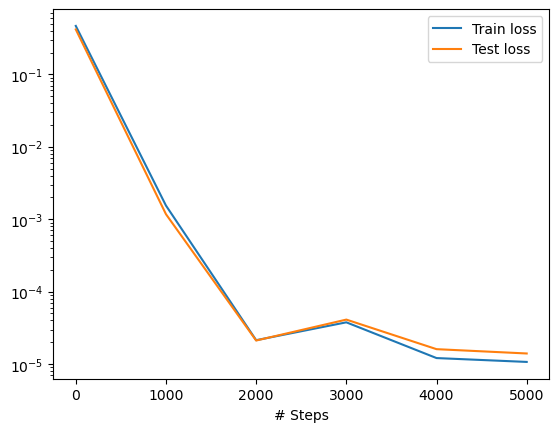

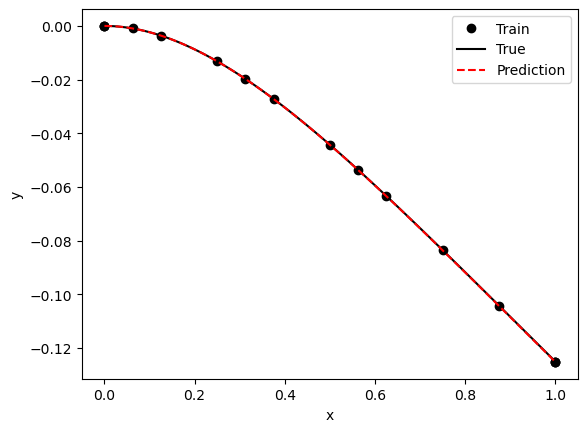

In [ ]:
losshistory, train_state = model.train(iterations=5000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)